# Groupe 11 - TP 2 - Raport

Membres du groupe:
- Oussama Khaloui --- khao1201
- Matthieu Tailleur --- taim1201
- Caroline Wang --- wanc1101
- Ahamada Chakiya --- ahac1101

## 1 - Analyse des données

### 1.a - Réduction des données

In [ ]:
# Importation des librairies basiques
import pandas as pd
import numpy as np

# Paramètres d'affichage des DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# librairies de visualisation
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

# Librairie sklearn
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score


# Modèle gaussien
from matplotlib import patches
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

#### Chargement des données

In [9]:
data_file_1 = "./donnees/orders_distance_stores_softmax.csv"
data_file_2 = "./donnees/order_products__prior_specials.csv"
data_orders_distance = pd.read_csv(data_file_1, index_col=0)
data_orders_products = pd.read_csv(data_file_2, index_col=0)

# Vérification du bon chargement des données et comparaison avec ce qui est attendu d'après l'énoncé
print(f"Le dataset orders_distance_stores_softmax contient {data_orders_distance.shape[0]} lignes et {data_orders_distance.shape[1]} attributs")
print(f"Le dataset order_products__prior_specials contient {data_orders_products.shape[0]} lignes et {data_orders_products.shape[1]} attributs")

Le dataset orders_distance_stores_softmax contient 136026 lignes et 9 attributs
Le dataset order_products__prior_specials contient 1172312 lignes et 5 attributs


Les datasets contiennent tous deux le nombre d'attributs attendu et beaucoup de lignes. L'objectif de cette partie sera de réduire leurs nombre - pour rendre nos algorithmes plus efficaces - tout en conservant le maximum d'information du dataset afin d'effectuer les meilleurs prédictions possibles.

#### Auscultation des données

On commence par visualiser quelques données pour nous faire une idée des datasets

In [10]:
# Obseravtion de quelques données
data_orders_distance.head()

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,210,0,2.304404,1438665,prior,9,1,18,3.0
1,210,0,2.304404,2850206,prior,36,0,7,2.0
2,210,0,2.304404,2406913,prior,42,0,8,3.0
3,210,0,2.304404,1155933,prior,43,2,23,2.0
4,210,0,2.304404,271697,prior,56,5,17,3.0


In [11]:
data_orders_distance.tail()

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
136021,206105,9,2.140636,1841888,prior,39,0,21,1.0
136022,206105,9,2.140636,1137676,prior,43,4,15,1.0
136023,206105,9,2.140636,1439511,prior,45,6,9,1.0
136024,206105,9,2.140636,1783607,prior,58,4,19,0.0
136025,206105,9,2.140636,1410956,prior,65,2,9,1.0


on constate la présence de de données catégoriques. on choisit d'encoder les valeurs de la colonne 'eval_set'

In [12]:
data_orders_distance['eval_set'].unique()

array(['prior'], dtype=object)

In [13]:
df_encoded = pd.get_dummies(data_orders_distance, columns=['eval_set'])
data_orders_distance['eval_set'] = df_encoded[['eval_set_prior']]

In [14]:
# Vérification
data_orders_distance['eval_set'].unique()

array([1], dtype=uint8)

In [15]:
data_orders_distance

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,210,0,2.304404,1438665,1,9,1,18,3.0
1,210,0,2.304404,2850206,1,36,0,7,2.0
2,210,0,2.304404,2406913,1,42,0,8,3.0
3,210,0,2.304404,1155933,1,43,2,23,2.0
4,210,0,2.304404,271697,1,56,5,17,3.0
...,...,...,...,...,...,...,...,...,...
136021,206105,9,2.140636,1841888,1,39,0,21,1.0
136022,206105,9,2.140636,1137676,1,43,4,15,1.0
136023,206105,9,2.140636,1439511,1,45,6,9,1.0
136024,206105,9,2.140636,1783607,1,58,4,19,0.0


In [16]:
data_orders_products.head()

,order_id,product_id,add_to_cart_order,reordered,special
0,15,19660,1,1,15
1,15,21195,2,1,0
2,15,7461,3,1,50
3,15,2996,4,1,0
4,15,32463,5,1,0


In [17]:
data_orders_products.tail()

,order_id,product_id,add_to_cart_order,reordered,special
1172307,3421069,21137,8,1,0
1172308,3421069,30391,9,1,15
1172309,3421069,18656,10,1,0
1172310,3421069,26940,11,1,15
1172311,3421069,19057,12,1,0


On affiche quelques informations caractérisant les données afin de mieux les appréhender.
Nous réutiliserons ces informations par la suite car elles sont caractéristiques des distributions des données. Nous chercherons donc à les retrouver après avoir réduit le nombre de lignes. 

In [18]:
data_orders_distance.describe()

,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,136026.000000,136026.000000,136026.000000,1.360260e+05,136026.0,136026.000000,136026.000000,136026.000000,134652.000000
mean,101827.940320,4.503374,1.253315,1.713599e+06,1.0,50.000000,2.884419,13.036853,2.848097
std,60550.815551,2.866815,0.656473,9.868517e+05,0.0,28.577485,1.887552,4.233527,2.537760
min,210.000000,0.000000,0.002863,1.500000e+01,1.0,1.000000,0.000000,0.000000,0.000000
25%,49210.000000,2.000000,0.764297,8.590620e+05,1.0,25.000000,1.000000,10.000000,1.000000
50%,100229.000000,5.000000,1.173100,1.718160e+06,1.0,50.000000,3.000000,13.000000,2.000000
75%,154378.000000,7.000000,1.656305,2.565938e+06,1.0,75.000000,4.000000,16.000000,4.000000
max,206105.000000,9.000000,4.843817,3.421069e+06,1.0,99.000000,6.000000,23.000000,30.000000


In [19]:
data_orders_products.describe()

,order_id,product_id,add_to_cart_order,reordered,special
count,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06
mean,1.710806e+06,2.558317e+04,7.311208e+00,7.744346e-01,9.745972e+00
std,9.865049e+05,1.403693e+04,6.661885e+00,4.179543e-01,1.497054e+01
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.571920e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00
50%,1.713000e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00
75%,2.563004e+06,3.801600e+04,1.000000e+01,1.000000e+00,1.500000e+01
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01


In [20]:
# Compte des types d'attributs
data_orders_distance.dtypes.value_counts()

int64      6
float64    2
uint8      1
dtype: int64

In [21]:
data_orders_products.dtypes.value_counts()

int64    5
dtype: int64

#### Nettoyage des données

##### Valeurs manquantes

On commence par regarder du côté des valeurs manquantes en regardant le pourcentage de valeurs manquantes dans pour chaque colonnes des datasets

In [22]:
print(f" -Table des valeurs manquantes dans le dataset order_distance_stores_softmax\n\n{data_orders_distance.isnull().sum()}")
print("\n")
print(f" -Table des valeurs manquantes dans le dataset order_products_prior_specials\n\n{data_orders_products.isnull().sum()}")

 -Table des valeurs manquantes dans le dataset order_distance_stores_softmax

user_id                      0
store_id                     0
distance                     0
order_id                     0
eval_set                     0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    1374
dtype: int64


 -Table des valeurs manquantes dans le dataset order_products_prior_specials

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
special              0
dtype: int64


Il manque environ 1% de valeurs dans le dataset order_distance_stores_softmax pour la colonne 'days_since_prior_order' indiquant le nombre de jours écoulés depuis le dernier achat.

On a envisagé d'ajouter un nouvel attribut 'first_order' (0 ou 1) pour indiquer si l'achat est le premier de l'utilisateur. On va tester cela plus tard dans notre rapport.

Pour l'instant, on remplace donc chaque valeurs manquante par -1.

In [23]:
data_orders_distance.fillna({'days_since_prior_order':-1},inplace=True)

In [24]:
# Vérification
print(f"Nombre de données NULL : {data_orders_distance['days_since_prior_order'].isnull().sum()}")

Nombre de données NULL : 0


#### Valeurs dupliquées

In [25]:
duplicates_df_products = data_orders_products[data_orders_products.duplicated()]
duplicates_df_products_sorted = duplicates_df_products.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_products_prior_specials \n{duplicates_df_products_sorted.sum()}")

duplicates_df_distance = data_orders_distance[data_orders_distance.duplicated()]
duplicates_df_distance_sorted = duplicates_df_distance.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans les données order_distance_stores_softmax \n{duplicates_df_distance_sorted.sum()}")

Nombre de valeurs dupliquées dans les données order_products_prior_specials 
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
special              0.0
dtype: float64
Nombre de valeurs dupliquées dans les données order_distance_stores_softmax 
user_id                   0.0
store_id                  0.0
distance                  0.0
order_id                  0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64


Il n'y a pas de lignes dupliquées dans les données.

##### Gestion des outliers

On commence par visualiser les colonnes pour lesquelles les outliers sont nombreux à l'aide de boxplots.

Boxplots des colonnes du dataset order_distance_stores_softmax


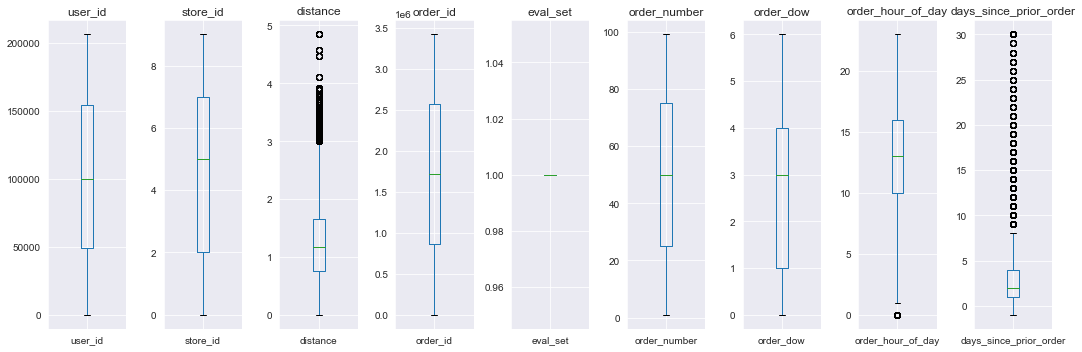

In [26]:
def detect_susceptible_outlier(data) : 
    fig, axes = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(15, 5))
    for i, col in enumerate(data.columns):
        data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

print("Boxplots des colonnes du dataset order_distance_stores_softmax")
detect_susceptible_outlier(data_orders_distance)

Boxplots des colonnes du dataset order_products_prior_specials


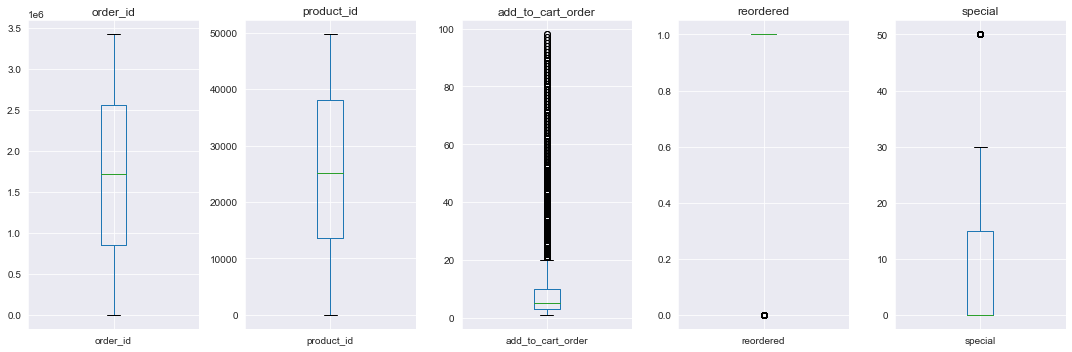

In [27]:
print("Boxplots des colonnes du dataset order_products_prior_specials")
detect_susceptible_outlier(data_orders_products)

Les attributs susceptibles d'avoir des outliers pour les données 'order_distance_stores_softmax' sont :
    + distance
    + order_hour_of_day
    + days_since_prior_order
Les attributs susceptibles d'avoir des outliers pour les données 'order_products_prior_specials' sont :
    + add_to_cart_order
    + special

Ces outliers peuvent toutefois encoder des informations importantes concernant le comportement des clients. Comme ils sont peu nombreux, nous choississons pour l'instant de les conserver dans le dataset et travaillerons dessus si les algorithmes le necessitent dans la suite

#### Intégration des données

##### Combinaison des datasets
On fusionne les datasets selon les id des commandes

In [28]:
data_orders = pd.merge(data_orders_products, data_orders_distance, on='order_id', how='inner')

In [29]:
# Vérification simple
data_orders.head()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,15,19660,1,1,15,54901,1,0.304608,1,51,3,11,2.0
1,15,21195,2,1,0,54901,1,0.304608,1,51,3,11,2.0
2,15,7461,3,1,50,54901,1,0.304608,1,51,3,11,2.0
3,15,2996,4,1,0,54901,1,0.304608,1,51,3,11,2.0
4,15,32463,5,1,0,54901,1,0.304608,1,51,3,11,2.0


#### Réduction

##### Etude des redondances


In [30]:
#classemenet des colonnes par nombre de valeurs redondantes
data_orders.nunique().sort_values()

eval_set                       1
reordered                      2
special                        4
order_dow                      7
store_id                      10
order_hour_of_day             24
days_since_prior_order        32
add_to_cart_order             98
order_number                  99
user_id                     1374
distance                   13736
product_id                 24860
order_id                  136026
dtype: int64

on constate que la colonne 'eval_set' possède les mêmes valeur spour chaque ligne. on choisit donc de supprimer cette colonne car elle n'apporte aucune information dans nos données

In [31]:
data_orders.drop(columns=['eval_set'],inplace=True)

##### Feature engineering rapide
Bien que cela ne soit pas demandé explicitemment dans le sujet du tp, nous regardons rapidement la corrélation 2 à 2 entre les différents attributs des données afin de pouvoir éliminer d'éventuelles redondances dans ces dernière au cas où nous ayons besoin d'accélerer l'entraîenment de nos algorithmes dans la suite.

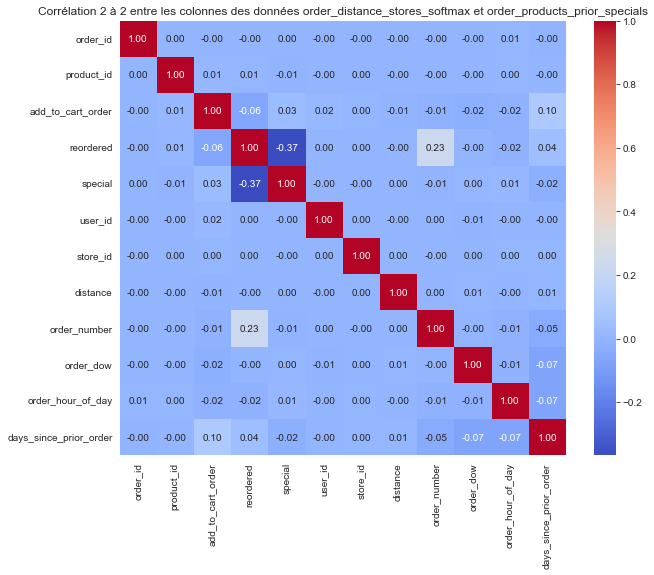

In [32]:
# Corrélation 2 à 2 pour les données order_distance_stores_softmax
correlation_matrix_orders = data_orders.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_orders, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Corrélation 2 à 2 entre les colonnes des données order_distance_stores_softmax et order_products_prior_specials')
plt.show()

Les attributs sont très peu corrélés ou non corrélés. On gardes toutes les features pour le moment mais nous n'écartons pas la possibilité de recourir à des techniques de reduction de dimensionalité si l'entraînement des algortihmes le nécessite dans la suite.

##### Réduction des données
Nous cherchons à présent à réduire le volume de données tout en conservant le maximum d'information ainsi que des données représentatives du dataset initial.

Pour cela, nous procédons à un échantillonage probabiliste **stratifié** de nos données.
Le caractère probabiliste de l'échantillonage assure de réduire le biais lié à la selection effectuée. L'aspect stratifié assure quant à lui d'obtenir un sous-ensemble de données **représentatif de la population originelle**

In [33]:
# On stratify selon l'attribut 'reordered' qui correspond à notre cible.
from sklearn.model_selection import train_test_split

# Assuming 'target' is the column representing classes/groups
_, sampled_df = train_test_split(data_orders, test_size=0.05, stratify=data_orders['reordered'], random_state=42)

# On visualise les statistiques des données obtenues
sampled_stats = sampled_df.describe()
print(sampled_stats.columns.values)

['order_id' 'product_id' 'add_to_cart_order' 'reordered' 'special'
 'user_id' 'store_id' 'distance' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [34]:
# Visualisation des statistiques sur les données avant sampling
data_orders.describe()

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06,1.172312e+06
mean,1.710806e+06,2.558317e+04,7.311208e+00,7.744346e-01,9.745972e+00,1.011486e+05,4.497209e+00,1.252174e+00,4.950891e+01,2.849628e+00,1.298660e+01,3.101219e+00
std,9.865049e+05,1.403693e+04,6.661885e+00,4.179543e-01,1.497054e+01,6.052976e+04,2.858121e+00,6.571061e-01,2.906399e+01,1.920069e+00,4.249346e+00,2.751127e+00
min,1.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.100000e+02,0.000000e+00,2.863073e-03,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,8.571920e+05,1.357500e+04,3.000000e+00,1.000000e+00,0.000000e+00,4.918600e+04,2.000000e+00,7.640387e-01,2.400000e+01,1.000000e+00,1.000000e+01,1.000000e+00
50%,1.713000e+06,2.514600e+04,5.000000e+00,1.000000e+00,0.000000e+00,9.935200e+04,4.000000e+00,1.171076e+00,4.900000e+01,3.000000e+00,1.300000e+01,3.000000e+00
75%,2.563004e+06,3.801600e+04,1.000000e+01,1.000000e+00,1.500000e+01,1.545560e+05,7.000000e+00,1.654696e+00,7.500000e+01,5.000000e+00,1.600000e+01,4.000000e+00
max,3.421069e+06,4.968300e+04,9.800000e+01,1.000000e+00,5.000000e+01,2.061050e+05,9.000000e+00,4.843817e+00,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


on compare les statistiques avant et après sampling pour voir si la diversité des données est aussi bien représentée qu'avant.

In [35]:
diff_tab = []
for col_name in sampled_df.columns.values:
    stat_pre_sampling = data_orders.describe()[col_name]
    stat_post_sampling = sampled_df.describe()[col_name]
    diff = 100 * abs(stat_post_sampling - stat_pre_sampling) / (stat_post_sampling + stat_pre_sampling)
    diff_tab.append(diff)
diff_tab

[count    90.476129
 mean      0.048462
 std       0.156523
 min      72.727273
 25%       0.010588
 50%       0.155653
 75%       0.215293
 max       0.001257
 Name: order_id, dtype: float64,
 count    90.476129
 mean      0.028282
 std       0.167641
 min       0.000000
 25%       0.436520
 50%       0.015910
 75%       0.187726
 max       0.000000
 Name: product_id, dtype: float64,
 count    90.476129
 mean      0.343111
 std       0.141904
 min       0.000000
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       0.000000
 Name: add_to_cart_order, dtype: float64,
 count    90.476129
 mean      0.000286
 std       0.000753
 min            NaN
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       0.000000
 Name: reordered, dtype: float64,
 count    90.476129
 mean      0.216205
 std       0.014235
 min            NaN
 25%            NaN
 50%            NaN
 75%       0.000000
 max       0.000000
 Name: special, dtype: float64,
 count    90.476129
 mea

on constate que les statistiques des distributions ont majoritairement été conservé après l'échantillonage. Cela infique que l'information et la représentativité des données a bien été conservée.

### 1.b - Préparation des données

#### Création des ensembles d'entraînement et de test
On sépare les données en ensembles d'entraînement et de test tout en conservant la diversité des données dans chacun de ces ensembles. pour cela, on utilise l'option 'stratfied' de la fonction train_test_split de sklearn

In [36]:
X = data_orders.drop(columns=['reordered']) # datas
y = data_orders['reordered'] # targets


# First, split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Then, split the training set into a smaller training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

#### Transformation

##### Normalisation des ensembles d'entraînement et de test
Les algorithmes que nous appliquerons par la suite (CNN et SVM) ne nécessitent pas de connaître la distribution des données.
Nous procédons donc à la normalisation des données afin de les ramener dans un intervalle connu.

In [37]:
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.fit_transform(X_test)
X_val_scaled = standard_scaler.fit_transform(X_val)

X_train = X_train_scaled
X_test = X_test_scaled
X_val = X_val_scaled

In [38]:
# Vérification
print(f"Moyenne de X_train_scaled = {X_train_scaled.mean()} et déviation standard = {X_train_scaled.std()}")
print(f"Moyenne de X_test_scaled = {X_test_scaled.mean()} et déviation standard = {X_test_scaled.std()}")
print(f"Moyenne de X_val_scaled = {X_val_scaled.mean()} et déviation standard = {X_val_scaled.std()}")

Moyenne de X_train_scaled = 4.6739405478225944e-17 et déviation standard = 1.0000000000000004
Moyenne de X_test_scaled = 3.82946408953279e-17 et déviation standard = 1.0000000000000002
Moyenne de X_val_scaled = -5.866518584353326e-17 et déviation standard = 0.9999999999999997


A l'issu des ces étapes de prétraitement, les données ont été standardisée et peuvent être desormais utilisées dans les algorithmes suivants.

### 1.c - Visualisations

In [ ]:
# Lirbairies de réductions des données
import umap
from sklearn.decomposition import PCA

Pour la visualisation des données, nous avons décidé de procéder à une réduction UMAP à deux composantes afin d'afficher la répartition de la classes reordered pour les données d'entrapinement et de test. Les sections en commentaires ont déjà été exécutées et on permis l'obtention de fichiers joints au dossier.

In [ ]:
#y_train_reshaped = y_train.values.reshape(-1, 1)
#y_test_reshaped = y_test.values.reshape(-1, 1)
#train = np.concatenate((X_train,y_train_reshaped),axis=1)
#test = np.concatenate((X_test,y_test_reshaped),axis=1)

In [ ]:
#reducer = umap.UMAP(n_components=2)
#umap_train = reducer.fit_transform(train)
#umap_test = reducer.fit_transform(test)

In [ ]:
#np.savetxt('données/UMAP_results_train.csv', X=umap_train, delimiter=';')  
#np.savetxt('données/UMAP_results_test.csv', X=umap_test, delimiter=';') 

In [ ]:
umap_results_train = np.loadtxt('données/UMAP_results_train.csv', delimiter=';', usecols=range(2))
umap_results_test = np.loadtxt('données/UMAP_results_test.csv', delimiter=';', usecols=range(2))

In [ ]:
fig_UMAPtrain = px.scatter(
    umap_results_train, x=0, y=1,
    color=y_train,labels={'Classe':'reordered',"0":"UMAP 0","1":"UMAP 1"}, title = "Répartition de la classe Reordered selon UMAP pour les données d'entraînement"
)
fig_UMAPtest = px.scatter(
    umap_results_test, x=0, y=1,
    color=y_test,labels={'Classe':'reordered',"0":"UMAP 0","1":"UMAP 1"}, color_continuous_scale="viridis",
    title = "Répartition de la classe Reordered selon UMAP pour les données de test"
)
fig_UMAPtrain.update_layout(scattermode="group",height=800)
fig_UMAPtest.update_layout(scattermode="group",height=800)
fig_UMAPtrain.show()
fig_UMAPtest.show()

In [ ]:
#pca_reducer = PCA(n_components=2)
#pca_train = pca_reducer.fit_transform(train)
#pca_test = pca_reducer.fit_transform(test)

In [ ]:
#np.savetxt('données/PCA_results_train.csv', X=pca_train, delimiter=';')  
#np.savetxt('données/PCA_results_test.csv', X=pca_test, delimiter=';') 

In [ ]:
pca_results_train = np.loadtxt('données/PCA_results_train.csv', delimiter=';', usecols=range(2))
pca_results_test = np.loadtxt('données/PCA_results_test.csv', delimiter=';', usecols=range(2))

In [ ]:
fig_PCAtrain = px.scatter(
    pca_results_train, x=0, y=1,
    color=y_train,labels={'Classe':'reordered',"0":"PCA 0","1":"PCA 1"}, title = "Répartition de la classe Reordered selon pca pour les données d'entraînement"
)
fig_PCAtest = px.scatter(
    pca_results_test, x=0, y=1,
    color=y_test,labels={'Classe':'reordered',"0":"PCA 0","1":"PCA 1"}, color_continuous_scale="viridis",
    title = "Répartition de la classe Reordered selon PCA pour les données de test"
)
fig_PCAtrain.update_layout(scattermode="group",height=800)
fig_PCAtest.update_layout(scattermode="group",height=800)
fig_PCAtrain.show()
fig_PCAtest.show()

La méthode de réduction par UMAP, contrairement à la réduction PCA fonctionne en n'assumant pas de relation linéaires entre les données. De plus, le PCA fonction sans informations sur les classes, il permet donc de visualiser les clusterings, tandis que UMAP fonctionne en considérant les classes et permet simplement une visualisation.

## 2 - Choix du modèle de prédiction

### 2.a - Modèle RNN et score F1

In [62]:
# Vérifier les formes des ensembles créés
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

# Assuming y_train and y_test are your target labels
# Convert them to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_val_one_hot = to_categorical(y_val)

y_train_one_hot[:5]

Shape of X_train: (703386, 11)
Shape of X_val: (234463, 11)
Shape of X_test: (234463, 11)


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Prédiction de la classe

In [63]:
loss_fn = keras.losses.CategoricalCrossentropy()
metrics_fn = keras.metrics.BinaryAccuracy()

In [65]:
# Define a function to create the model based on hyperparameters
def create_model(optimizer='adam', neurons_layer1=64, neurons_layer2=64):
    model = Sequential()    
    model.add(keras.Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons_layer1, activation='relu'))
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics_fn])
    return model

# Wrap the create_model function with KerasClassifier
keras_model = KerasClassifier(model=create_model, neurons_layer1=64, neurons_layer2=64, metrics=[metrics_fn])

# Define the grid of hyperparameters to search
param_grid = {
    'neurons_layer1': [32, 64, 128],
    'neurons_layer2': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop']
}

# Define F1 score as the metric
f1_scorer = make_scorer(f1_score, average='micro')

# Initialize GridSearchCV with F1 score as the metric
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, scoring=f1_scorer)
# Perform grid search
grid_result = grid.fit(X_train, y_train_one_hot, epochs=3, batch_size=64, validation_data=(X_val, y_val_one_hot), verbose=1)

Epoch 1/3
7327/7327 [==============================] - 6s 730us/step - loss: 0.4238 - binary_accuracy: 0.8062 - val_loss: 0.4177 - val_binary_accuracy: 0.8057
Epoch 2/3
7327/7327 [==============================] - 5s 711us/step - loss: 0.4151 - binary_accuracy: 0.8086 - val_loss: 0.4151 - val_binary_accuracy: 0.8078
Epoch 3/3
7327/7327 [==============================] - 3s 421us/step
Epoch 1/3
7327/7327 [==============================] - 6s 723us/step - loss: 0.4234 - binary_accuracy: 0.8055 - val_loss: 0.4173 - val_binary_accuracy: 0.8064
Epoch 2/3
7327/7327 [==============================] - 5s 721us/step - loss: 0.4149 - binary_accuracy: 0.8079 - val_loss: 0.4137 - val_binary_accuracy: 0.8096
Epoch 3/3
7327/7327 [==============================] - 3s 428us/step
Epoch 1/3
7327/7327 [==============================] - 5s 714us/step - loss: 0.4222 - binary_accuracy: 0.8064 - val_loss: 0.4164 - val_binary_accuracy: 0.8075
Epoch 2/3
7327/7327 [==============================] - 5s 714us/ste

In [66]:
# Display results
print("- Best parameters found: ", grid_result.best_params_)
print("\n")
print("- Best F1 score found: ", round(grid_result.best_score_,2))

- Best parameters found:  {'neurons_layer1': 128, 'neurons_layer2': 64, 'optimizer': 'rmsprop'}


- Best F1 score found:  0.81


#### Verification sur les données de test

In [67]:
best_model = grid_result.best_estimator_

# Faire des prédictions sur l'ensemble de test avec le meilleur modèle
y_pred_best = best_model.predict(X_test)

f1_best = f1_score(y_test_one_hot, y_pred_best, average='micro')

# Afficher les résultats pour le meilleur modèle
print("Best model performance:")
print("F1 Score:", round(f1_best,3))

7327/7327 [==============================] - 3s 427us/step
Best model performance:
F1 Score: 0.811


### 2.b - Modèle SVM et score F1

On écrit une fonction qui permettra de chercher les hyperparamètres du modèle, en fonction du type de noyau choisi.

In [39]:
# Recherche d'hyperpatamètres en fonction du noyau
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

def hyper_parameters_search(model, kernel, X_train, y_train):
        if kernel == 'linear':
            C_range = [1,10,100,1000]
            param_grid = dict(C=C_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau RBF : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'rbf':
            C_range = [1,10,100,1000]
            gamma_range = [1,0.1,0.001,0.0001]
            param_grid = dict(gamma=gamma_range, C=C_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau RBF : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'sigmoid':
            coef0_range = [-5, -3, -1, -0.1, 0.0, 0.1, 1]
            param_grid = dict(coef0=coef0_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau sigmoïde : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        elif kernel == 'poly':
            coef0_range = [-5, -3, -1, -0.1, 0.0, 0.1, 1]
            degree_range = [2, 3, 4, 5, 6, 7]
            param_grid = dict(coef0=coef0_range, degree = degree_range)
            cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
            grid = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='accuracy')
            grid.fit(X_train, y_train)
            print(grid.best_score_, " pour les hyperparamètres suivants, noyau polynomial : ", grid.best_params_)
            return grid.best_estimator_, grid.best_params_
        print("Erreur recherche hyper-paramètres")
        return model     

Pour chaque type de noyau, on entraine un modèle correspondant pour ensuite l'évaluer et chercher ses hyperparamètres. On enregistre ensuite ces données dans un fichier, à partir duquel on pourra récupérer le modèle entrainé

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import joblib

kernel_values = ['linear', 'rbf', 'sigmoid', 'poly']
for kernel in kernel_values :
    print(f'----- Modèle de noyau {kernel} -----')
    
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_train_scaled, y_train)
    y_pred = svm_model.predict(X_test_scaled)
    
    # Évaluation du modèle    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Matrice de confusion :')
    print(conf_matrix)
    
    f1_svm = f1_score(y_test, y_pred)
    print(f'Score F1 : {f1_svm}')
    
    # Recherche des hyperparamètres
    best_svm_model, best_svm_param = hyper_parameters_search(svm_model, kernel, X_train=X_train_scaled, y_train=y_train)
    best_svm_model.fit(X_train_scaled, y_train)
    best_y_pred = best_svm_model.predict(X_test_scaled)

    # Évaluation du meilleur
    best_conf_matrix = confusion_matrix(y_test, best_y_pred)
    print(f'Matrice de confusion')
    print(best_conf_matrix)
    
    best_f1_svm = f1_score(y_test, best_y_pred)
    print(f'Score F1 : {best_f1_svm}')
    
    # Sauvegarde du modèle et des hyperparamètres dans un fichier
    joblib.dump(best_svm_model, f'modele_svm_{kernel}.pkl')
    joblib.dump(best_svm_param, f'hyperparametres_svm_{kernel}.pkl')

----- Modèle de noyau linear -----


On récupère les données précédemment enregistrées.

In [ ]:
# Chargement des modèle et des hyperparamètres à partir des fichiers sauvegardés
kernel_values = ['linear', 'rbf', 'sigmoid', 'poly']
for kernel in kernel_values :
    modele_svm = joblib.load(f'modele_svm_{kernel}.pkl')
    hyperparametres_svm = joblib.load(f'hyperparametres_svm_{kernel}.pkl')
    print(f'Meilleurs paramètres du modèle SVM avec noyau de type {kernel} : {hyperparametres_svm}')

## 3 - Conclusion

### 3.a -



### 3.b -

Les hyperparamètres utilisés pour le modèle SVM sont les suivants :

- Pour le noyau linear :
    - C : la valeur de pénalité du terme d'erreur.

- Pour le noyau rbf :
    - C : la valeur de pénalité du terme d'erreur.
    - gamma : la valeur du coefficient du noyau RBF.

- Pour le noyau sigmoid :
    - coef0 : la valeur de l'ordonnée à l'origine dans le noyau sigmoïde.

- Pour le noyau poly :
    - coef0 : la valeur de l'ordonnée à l'origine dans le noyau polynomial.
    - degree : la valeur du degré du noyau polynomial.

---

Les hyperparamètres utilisés pour le modèle RNN sont les suivants :
- neurons_layer1 : le nombre de neurones dans la première couche du modèle (32, 64 ou 128).
- neurons_layer2 : le nombre de neurones dans la deuxième couche du modèle (32, 64 ou 128).
- optimizer : l'optimiseur utilisé pour l'entraînement du modèle (adam ou rmsprop).

Y en a d'autres qui peuvent être utilisés pour améliorer les performances du modèle, comme le nombre de couches, le taux d'apprentissage, le nombre d'époques, etc. mais on a choisi de se concentrer sur ces trois hyperparamètres pour simplifier le processus de recherche des meilleurs hyperparamètres.

*Plus le nombre de neurones est élevé, plus le modèle est complexe et plus il a de chances de sur-apprendre.*

### 3.c -

Fondamentalement les 2 architectures proposées permettent bien de répondre à la question que l'on se pose.
Cependant, il aurait probablement été judicieux de commencer notre étude par l'implémementation d'algorithmes plus simples une regression logistique (on aurait pu essayé knn mais son fonctionnement interne le rend inutilisable en pratique étant donné la taille de notre dataset contraireemnt à la régression logistique qui procède en utilisant des petits batch).
En effet, ces modèles sont généralement rapides et faciles à implémenter et aurait pu donner des résultats tout à fait satisfaisant.

Aussi, les classifieurs SVM sont généralement assez couteux en ressources - donc en temps de calcul - sur les datasets possédant beaucoup de données comme celui avec lequel nous avons travaillé. A l'inverse les réseaux de neurones sont particulièrement bien adaptés pour traiter de grandes quantités de données.

Un autre critère à prendre en compte est la structure des données. Ici nous travaillons avec des données struturées (des tableaux et non des images ou du son). A nouveau les réseaux de neurones pont particulièrement bien adaptés au traitement de ce genre de données.

De plus, la plupart de nos données suivent approximativement une loi normale qui ets généralement bien estimé par les réseaux de neurones qui sont des modèles paramétriques (lorsqu'ils sont petits) et moins bien par les SVM qui sont des modèles non paramétriques. toutefois, comme en pratique nos données ne suivent pas tout a fait de loi normale, l'utilisation de modèle paramétriques et non paramétriques peut être justifiée.

Ainsi, l'utilisation de réseaux de neurones pour résoudre notre problème semble être la plus adaptée.

### 3.d -

Le score F1 est très bon, il est proche de 1. Cela signifie que le modèle a bien été entrainé et que ses capacités de prédiction sont satisfaisantes.

On peut également envisager de créer des modèles qui prédisent le supermarché qui sera visité ensuite.